In [1]:
import pandas as pd
import networkx as nx
import warnings
warnings.filterwarnings('ignore')


import preprocessing as pp
import creation_matrices as cm
import fusion_networks as fn
import extraction_classification as ec
import matplotlib as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter


In [2]:
#Names used to load and save data
#Example cancer type used: lihc
tumor = 'lihc'
m_norm = 'mirna_norm_'+str(tumor)
m_canc = 'mirna_canc_'+str(tumor)
g_norm = 'gene_norm_'+str(tumor)
g_canc = 'gene_canc_'+str(tumor)

# Importing and saving data 

In [ ]:
#The first time we import the data extracted from gmql and we build matrices with genes in the rows and patients in the columns
#We save them into a folder Datasets_created
import gmql as gl


def import_data(m_canc,m_norm,g_canc,g_norm):
    #Import datasets and Create matrices using normalized counts
    mir_canc= gl.load_from_path(local_path='./Datasets/'+str(m_canc))
    mir_canc = mir_canc.materialize('./Datasets_created/'+str(m_canc), all_load=True)
    mir_cancer= mir_canc.to_matrix(index_regs=["mirna_id", 'gene_symbol'], columns_meta=["biospecimen__bio__bcr_analyte_barcode"],values_regs=["reads_per_million_mirna_mapped"],  fill_value=0)
    #Create matrix of lenghts of mirna genes
    miRNACancerlength=mir_canc.to_matrix(index_regs=['mirna_id', 'gene_symbol'], values_regs=['start','stop'])
    del(mir_canc)
    
    mir_norm= gl.load_from_path(local_path='./Datasets/'+str(m_norm))
    mir_norm = mir_norm.materialize('./Datasets_created/'+str(m_norm), all_load=True)
    mir_normal= mir_norm.to_matrix(index_regs=["mirna_id", 'gene_symbol'], columns_meta=['biospecimen__bio__bcr_analyte_barcode'],values_regs=["reads_per_million_mirna_mapped"],fill_value=0)
    miRNANormallength=mir_norm.to_matrix(index_regs=['mirna_id', 'gene_symbol'], values_regs=['start','stop'])
    del(mir_norm)
    
    gene_canc= gl.load_from_path(local_path='./Datasets/'+str(g_canc))
    gene_canc= gene_canc.materialize('./Datasets_created/'+str(g_canc), all_load=True)
    gene_cancer= gene_canc.to_matrix(index_regs=['ensembl_gene_id','gene_symbol'], columns_meta=["biospecimen__bio__bcr_analyte_barcode"],values_regs=["fpkm"])
    del(gene_canc)
    
    gene_norm= gl.load_from_path(local_path='./Datasets/'+str(g_norm))
    gene_norm = gene_norm.materialize('./Datasets_created/'+str(g_norm), all_load=True)
    gene_normal= gene_norm.to_matrix(index_regs=['ensembl_gene_id','gene_symbol'], columns_meta=["biospecimen__bio__bcr_analyte_barcode"],values_regs=["fpkm"])
    del(gene_norm)
    
    #Save the matrices with gene types
    mir_cancer.to_csv('./Matrices/'+str(m_canc))
    mir_normal.to_csv('./Matrices/'+str(m_norm))
    gene_cancer.to_csv('./Matrices/'+str(g_canc))
    gene_normal.to_csv('./Matrices/'+str(g_norm))
    miRNACancerlength.to_csv('./Matrices/'+str(m_canc)+'length')
    miRNANormallength.to_csv('./Matrices/'+str(m_norm)+'length')
    return mir_cancer, miRNACancerlength, mir_normal, miRNANormallength, gene_cancer, gene_normal

In [ ]:
mir_canc, mir_canc_length, mir_norm, mir_norm_length, gene_canc, gene_norm = import_data(m_canc, m_norm,g_canc, g_norm)

# Upload matrices

In [3]:
#We upload the saved matrices
mir_canc = pd.read_csv('./Matrices/'+str(m_canc), index_col=[0,1], header=[0,1], skiprows=0)
mir_canc_length = pd.read_csv('./Matrices/'+str(m_canc)+'length', index_col=[0,1],header=[0,1], skiprows=0)
mir_norm = pd.read_csv('./Matrices/'+str(m_norm), index_col=[0,1], header=[0,1], skiprows=0)
mir_norm_length = pd.read_csv('./Matrices/'+str(m_norm)+'length', index_col=[0,1], header=[0,1], skiprows=0)
gene_canc = pd.read_csv('./Matrices/'+str(g_canc), index_col=[0,1], header=[0,1], skiprows=0)
gene_norm = pd.read_csv('./Matrices/'+str(g_norm), index_col=[0,1], header=[0,1], skiprows=0)


# Pre-processing

In [ ]:
#We pre-process the data to obtain the normal and cancer matrix
#All details of preprocessing are explained in preprocessing.py script
preprocessed = pp.Preprocessing(mir_canc, mir_canc_length, mir_norm, mir_norm_length, gene_canc, gene_norm, tumor)
normal = preprocessed.Normal
cancer = preprocessed.Cancer
indices = preprocessed.Indices

# Creation of the networks

In [ ]:
#We create the two networks that are the sum of Euclidean and Pearson matrices
#All details of the construction are explained in creation_matrices.py script
normal_perc = [75,74,73,70,65,64.5,63,62,60,58,57,55,54,53,50]
cancer_perc = [65,64.5,63,62,60,58,57,55,54,53,50,44.5,40,35,30]
matrices = cm.Net(normal, cancer, indices, tumor, normal_perc, cancer_perc)
n_sum = matrices.n_sum
c_sum = matrices.c_sum

# Fusion of the summed networks

In [ ]:
#All details of the fusion are explained in fusion_networks.py script
fused = fn.fusion_snf(n_sum, c_sum, str(tumor))
fused_thr = fused.fused_thr

# Construction of the graph for the Gephi software

In [13]:
#We build the graph using networkx and we save it in Gephi format
graph = nx.from_numpy_array(fused_thr)
nx.write_gexf(graph,'./Graphs/graph_'+str(tumor)+'.gexf')

# After extraction of communities with Gephi

In [14]:
#After having saved the communities with gephi and having saved the indices of them
#We extract the ensembl and the relative expressions
communities = pd.read_csv('./Extracted/comm_'+str(tumor)+'.csv', sep=',')
communities_genes = normal.index[communities['Id']]
pd.DataFrame(communities_genes).to_csv('./Extracted/genes_comm_'+str(tumor)+'.csv')

In [15]:
comm_genes_norm=pd.DataFrame(index=communities_genes, columns=normal.columns)
comm_genes_canc=pd.DataFrame(index=communities_genes, columns=cancer.columns)

In [19]:
def extract_communities(A, A_norm, A_canc, N, C):
    for i in N.index:
        for j in A:
            if i==j:
                A_norm[A_norm.index==j]=(N[N.index==i].get_values())
     
    for i in C.index:
        for j in A:
            if i==j:
                A_canc[A_canc.index==j]=(C[C.index==i].get_values())
                
    return A_norm, A_canc

comm_genes_norm, comm_genes_canc = extract_communities(communities_genes, comm_genes_norm, comm_genes_canc, normal, cancer)
comm_genes_norm.to_csv('./Extracted/exp_comm_norm'+str(tumor)+'.csv')
comm_genes_canc.to_csv('./Extracted/exp_comm_canc'+str(tumor)+'.csv')

In [8]:
#We load the expressions of DE genes found with t-test statistic
de_norm = pd.read_csv('./Extracted/exp_de_norm'+str(tumor)+'.csv', index_col=0, header=0)
de_canc = pd.read_csv('./Extracted/exp_de_canc'+str(tumor)+'.csv', index_col=0, header=0)

100%|██████████| 100/100 [48:49<00:00, 28.56s/it]


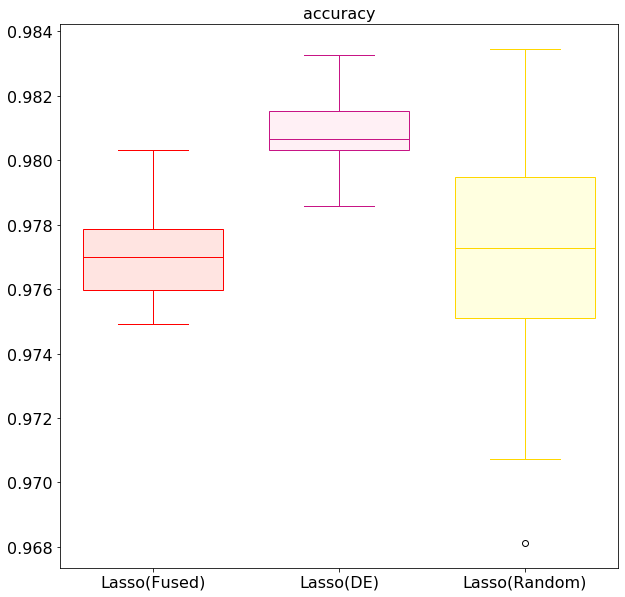

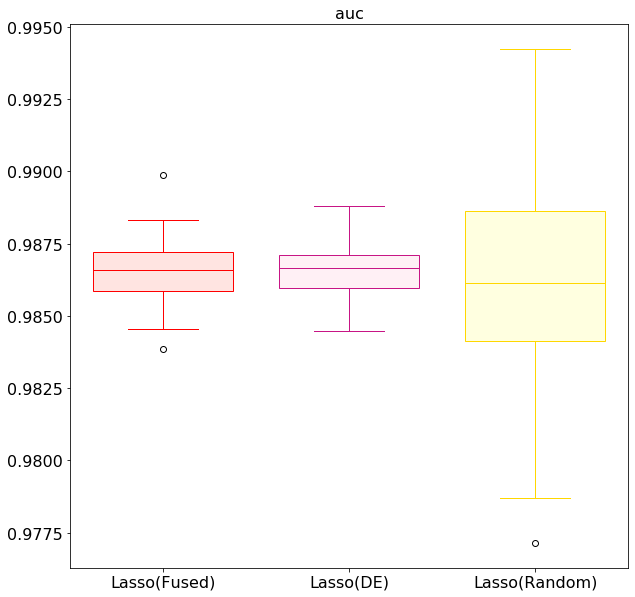

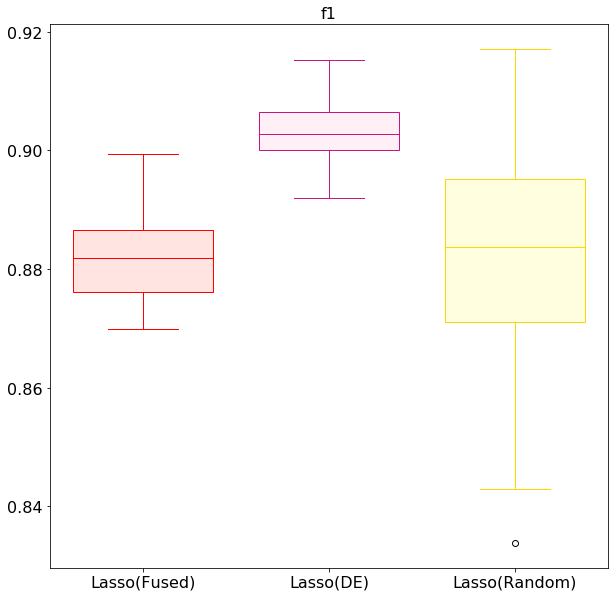

In [21]:
#We compute the computational validation of the genes extracted (integrated communities genes (IC), DE and Random)
#All details are in extraction_classification.py script
rf = ec.RF(normal, cancer, comm_genes_norm, comm_genes_canc, de_norm, de_canc, str(tumor))

In [ ]:
#Boxplots of the classification performances 
K=pd.read_csv('./Auc_acc_f1/auc_acc_f1_IC_'+str(tumor)+'.csv', index_col=0)
X=pd.read_csv('./Auc_acc_f1/auc_acc_f1_DE_'+str(tumor)+'.csv', index_col=0)
Y=pd.read_csv('./Auc_acc_f1/auc_acc_f1_random_'+str(tumor)+'.csv', index_col=0)

name_k='$IC_L$'
name_x='$DE_L$'
name_y='$Rand_L$'

what='accuracy'
fig, ax = plt.subplots(figsize=(10,10))
bp0 = ax.boxplot(K[what].values, positions=[0.1], 
                 patch_artist=True, boxprops=dict(facecolor="C3"))
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp0[element], color='black')
for patch in bp0['boxes']:
        patch.set(facecolor='dimgrey')
bp1 = ax.boxplot(X[what].values, positions=[0.3], 
                 patch_artist=True, boxprops=dict(facecolor="C3"))
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp1[element], color='black')
for patch in bp1['boxes']:
        patch.set(facecolor='grey')
bp2 = ax.boxplot(Y[what].values, positions=[0.5],
                 patch_artist=True, boxprops=dict(facecolor="C6"))
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp2[element], color='black')
for patch in bp2['boxes']:
        patch.set(facecolor='darkgrey')  
ax.set_xlim(0,0.6)
ax.set_title('Accuracy', fontsize=24)
ax.yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
plt.xticks([0.1,0.3,0.5],[str(name_k),str(name_x), str(name_y)], fontsize=20)
plt.yticks(np.arange(0.985,1, step=0.005),fontsize=24)
plt.savefig('./Boxplot_RF/boxplot_'+str(what)+'lasso_IC_DE_Random_'+str(tumor)+'.png', format='png',bbox_inches='tight',dpi=600)  

what='auc'
fig, ax = plt.subplots(figsize=(10,10))
bp0 = ax.boxplot(K[what].values, positions=[0.1], 
                 patch_artist=True, boxprops=dict(facecolor="C3"))
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp0[element], color='black')
for patch in bp0['boxes']:
        patch.set(facecolor='dimgrey')
bp1 = ax.boxplot(X[what].values, positions=[0.3], 
                 patch_artist=True, boxprops=dict(facecolor="C3"))
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp1[element], color='black')
for patch in bp1['boxes']:
        patch.set(facecolor='grey')
bp2 = ax.boxplot(Y[what].values, positions=[0.5],
                 patch_artist=True, boxprops=dict(facecolor="C6"))
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp2[element], color='black')
for patch in bp2['boxes']:
        patch.set(facecolor='darkgrey') 
#ax.legend([ bp2["boxes"][0], bp1['boxes'][0]], ['N2V_all', 'Random'], loc='upper right')
ax.set_xlim(0,0.6)
ax.set_title('AUC', fontsize=24)
ax.yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
plt.xticks([0.1,0.3,0.5],[str(name_k),str(name_x), str(name_y)], fontsize=20)
plt.yticks(np.arange(0.990,1, step=0.005),fontsize=24)
plt.savefig('./Try/Boxplot_RF/boxplot_'+str(what)+'lasso_IC_DE_Random_'+str(tumor)+'.png', format='png',bbox_inches='tight',dpi=600)  

what='f1'
fig, ax = plt.subplots(figsize=(10,10))
bp0 = ax.boxplot(K[what].values, positions=[0.1], 
                 patch_artist=True, boxprops=dict(facecolor="C3"))
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp0[element], color='black')
for patch in bp0['boxes']:
        patch.set(facecolor='dimgrey')
bp1 = ax.boxplot(X[what+str('_rand')].values, positions=[0.3], 
                 patch_artist=True, boxprops=dict(facecolor="C3"))
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp1[element], color='black')
for patch in bp1['boxes']:
        patch.set(facecolor='grey')
bp2 = ax.boxplot(Y[what+str('_rand')].values, positions=[0.5],
                 patch_artist=True, boxprops=dict(facecolor="C6"))
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp2[element], color='black')
for patch in bp2['boxes']:
        patch.set(facecolor='darkgrey')
ax.set_xlim(0,0.6)

ax.set_title('F1 score', fontsize=24)
ax.yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
plt.xticks([0.1,0.3,0.5],[str(name_k),str(name_x), str(name_y)], fontsize=20)
plt.yticks(np.arange(0.945,0.99, step=0.01),fontsize=24)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.savefig('./Try/Boxplot_RF/boxplot_'+str(what)+'lasso_IC_DE_Random_'+str(tumor)+'.png', format='png',bbox_inches='tight',dpi=600)  



